U-Net

/root/miniconda3/envs/dhcp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


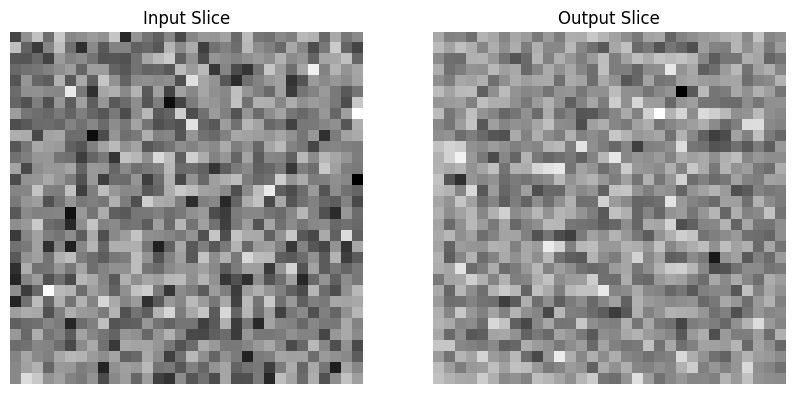

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# 定义 UNet 结构
class UNet(nn.Module):
    def __init__(self, C_in=1, C_hid=[16, 32, 64, 128, 128], C_out=1, K=3):
        super(UNet, self).__init__()
        self.conv1 = nn.Conv3d(C_in, C_hid[0], K, stride=1, padding=K//2)
        self.conv2 = nn.Conv3d(C_hid[0], C_hid[1], K, stride=2, padding=K//2)
        self.conv3 = nn.Conv3d(C_hid[1], C_hid[2], K, stride=2, padding=K//2)
        self.conv4 = nn.Conv3d(C_hid[2], C_hid[3], K, stride=2, padding=K//2)
        self.conv5 = nn.Conv3d(C_hid[3], C_hid[4], K, stride=1, padding=K//2)
        
        self.deconv4 = nn.Conv3d(C_hid[4]+C_hid[3], C_hid[3], K, stride=1, padding=K//2)
        self.deconv3 = nn.Conv3d(C_hid[3]+C_hid[2], C_hid[2], K, stride=1, padding=K//2)
        self.deconv2 = nn.Conv3d(C_hid[2]+C_hid[1], C_hid[1], K, stride=1, padding=K//2)
        self.deconv1 = nn.Conv3d(C_hid[1]+C_hid[0], C_hid[0], K, stride=1, padding=K//2)
        self.deconv0 = nn.Conv3d(C_hid[0], C_out, K, stride=1, padding=K//2)
        
        self.up = nn.Upsample(scale_factor=2, mode='trilinear', align_corners=False)
        
    def forward(self, x):
        x1 = F.leaky_relu(self.conv1(x), 0.2)
        x2 = F.leaky_relu(self.conv2(x1), 0.2)
        x3 = F.leaky_relu(self.conv3(x2), 0.2)
        x4 = F.leaky_relu(self.conv4(x3), 0.2)
        x  = F.leaky_relu(self.conv5(x4), 0.2)

        x = torch.cat([x, x4], dim=1)
        x = F.leaky_relu(self.deconv4(x), 0.2)
        
        x = self.up(x)
        x = torch.cat([x, x3], dim=1)
        x = F.leaky_relu(self.deconv3(x), 0.2)
        
        x = self.up(x)
        x = torch.cat([x, x2], dim=1)
        x = F.leaky_relu(self.deconv2(x), 0.2)
        
        x = self.up(x)
        x = torch.cat([x, x1], dim=1)
        x = F.leaky_relu(self.deconv1(x), 0.2)
        
        x = self.deconv0(x)
        return x

# 创建一个 3D 输入样例
B, C, D, H, W = 1, 1, 32, 32, 32  # 批次1，通道1，尺寸 32x32x32
input_data = torch.randn(B, C, D, H, W)  # 随机生成一个 3D 体数据

# 初始化 UNet
model = UNet(C_in=1, C_out=1)

# 运行模型
output_data = model(input_data)

# 可视化：选择中间的一个切片进行展示
slice_idx = D // 2  # 取中间的 2D 切片
input_slice = input_data[0, 0, slice_idx, :, :].detach().numpy()
output_slice = output_data[0, 0, slice_idx, :, :].detach().numpy()

# 画图
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(input_slice, cmap='gray')
ax[0].set_title('Input Slice')
ax[0].axis('off')

ax[1].imshow(output_slice, cmap='gray')
ax[1].set_title('Output Slice')
ax[1].axis('off')

plt.show()
